# **Libraries**

In [1]:
%pip install osmnx networkx matplotlib scipy

In [2]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import random
from scipy import stats

# **Task 1**

In [3]:
#Road Network Utilities

class NetworkLoader:
    """
    Loads and manages road networks from OpenStreetMap.
    It downloads the map of a city and make it ready to use.
    """

    def __init__(self, address, dist=1000, network_type='drive'):
        """
        Initialize by loading a road network.

        Args:
            address: The address to download ('Berlin, Germany')
            dist: How far around the address to download, in meters (1000m = 1km)
            network_type: What type of roads to include ('drive'=cars, 'walk'=walking, 'bike'=bicycles)

        It automatically downloads the map and adds a 'travel_time' to each road (street).
        """
        self.address = address
        self.dist = dist
        self.network_type = network_type
        # Download the actual map from OpenStreetMap
        self.G = self._load_berlin_road_network()
        # Calculate how long it takes to drive each street
        self._add_travel_times()

    def _load_berlin_road_network(self):
        """
        Get the road network for an address.
        It connects to OpenStreetMap and downloads all the streets around the address. Returns them as a graph (network).
        """
        return ox.graph_from_address(self.address, dist=self.dist, network_type=self.network_type)

    def _add_travel_times(self):
        """
        Add a 'travel_time' attribute to each edge based on speed limits.

        An edge is a street connecting two intersections (nodes).
        We calculate: travel_time = street_length / speed_limit

        This tells us how many minutes it takes to drive each street.
        If we don't know the speed limit, we assume 30 km/h.
        """
        for u, v, k, data in self.G.edges(data=True, keys=True):
            # Get the speed limit for this street (default: 30 km/h if unknown)
            speed = data.get("maxspeed", 30)

            # Sometimes there are multiple speed limits (for example during different times of day)
            # We just take the first one to keep it simple
            if isinstance(speed, list):
                speed = speed[0]

            # Calculate travel time in minutes
            # length is in meters, speed is in km/h
            # We convert: (meters / (km/h * 1000/60)) = minutes
            data["travel_time"] = data["length"] / (float(speed) * 1000/60)

In [4]:
#Traffic Simulation

class Car:
    """
    Represents a single car on the road network.
    A car is a simple object that has a location and knows where it wants to go.
    """

    def __init__(self, start, destination):
        """
        Create a car with a starting location and destination.

        Args:
            start: Starting intersection (node), where the car begins
            destination: Destination intersection (node), where the car wants to go

        The car doesn't have a route yet.
        """
        self.current_location = start
        self.destination = destination
        # This will store the path (list of streets/nodes) the car needs to follow
        self.path = []


class TrafficSimulation:
    """
    Manages traffic simulation on a road network.
    This is the main class that controls the entire simulation. It creates cars, moves them every time step,
    and checks for traffic jams
    """

    def __init__(self, G, num_cars=100, num_steps=10):
        """
        Initialize the simulation.

        Args:
            G: The road network graph (the map of streets)
            num_cars: How many cars to simulate (default is set to 100)
            num_steps: How many simulation steps to run (default is set to 10)

        A 'step' is one time unit. Each step, all cars move one street forward
        (unless they're stuck in traffic).
        """
        self.G = G
        self.num_cars = num_cars
        self.num_steps = num_steps
        self.cars = []  # Will be filled with Car objects

    def move_cars(self):
        """
        Move all cars one step forward.

        For each car:
        1. If it doesn't have a route yet, calculate the shortest path to destination
        2. If it reached the destination, stop moving
        3. Otherwise, move to the next street (unless there's a traffic jam)
        4. If too many cars are on the same street, the car waits (stays in place)
        """
        for car in self.cars:
            # Does this car know where to go?
            if not car.path:
                # Find the shortest path from current location to destination
                # We use 'travel_time' as the weight (cause it prefers faster routes)
                try:
                    full_path = nx.shortest_path(self.G, car.current_location, car.destination, weight="travel_time")
                    # Remove the starting node (where the car already is) from the path
                    car.path = full_path[1:]
                except nx.NetworkXNoPath:
                    # No route exists to this destination (can happen in real maps)
                    # Just mark the car as already at destination so it stops trying
                    car.current_location = car.destination
                    continue

            # Has the car reached its destination?
            if car.current_location == car.destination:
                continue

            # Get the next street (next node) to drive to
            next_node = car.path.pop(0)

            # Check if this street is too crowded
            # Count how many OTHER cars want to go to the same next_node from current location
            cars_on_edge = sum(1 for c in self.cars if c.current_location == car.current_location and c.path and c.path[0] == next_node)

            # If too many cars, create a traffic jam (car waits in place)
            if cars_on_edge > 5:  # The threshold for a "jam"
                # Put the next node back in the path so the car tries again next step
                car.path.insert(0, next_node)
            else:
                # No traffic jam, car can move to the next street
                car.current_location = next_node

    def simulate_traffic(self):
        """
        Run the traffic simulation.

        1. Create random cars with random starts and destinations
        2. For each time step, move all cars and print progress
        3. Return the list of all cars after simulation finishes
        """
        # Get all intersections (nodes) in the map
        nodes = list(self.G.nodes())

        # Create random cars - each starts and ends at a random intersection
        self.cars = [Car(random.choice(nodes), random.choice(nodes)) for _ in range(self.num_cars)]

        # Run the simulation for the specified number of steps
        for step in range(self.num_steps):
            # Move all cars one step
            self.move_cars()

            # Print progress (how many cars reached their destination)
            cars_at_dest = sum(1 for c in self.cars if c.current_location == c.destination)
            print(f"Step {step + 1}: Total cars at destination: {cars_at_dest}/{self.num_cars}")

        return self.cars


class NetworkVisualizer:
    """
    Visualizes the road network with traffic.
    It creates a picture showing:
      Thicker streets = more cars (traffic jam)
      Redder streets = more cars (traffic jam)
      Light streets = few or no cars
    """

    def __init__(self, G):
        """
        Initialize with a road network.
        """
        self.G = G

    def edge_car_counts(self, cars):
        """
        Count the number of cars on each edge (street).
        An edge connects two intersections. We count how many cars are currently trying to drive on each edge.

        Returns a dictionary: {(from_node, to_node): number_of_cars, ...}
        """
        counts = {}
        for car in cars:
            # Is the car still moving (does it have a path)?
            if car.path:
                # What's the next street this car wants to drive on?
                next_node = car.path[0]

                # Create a key for this edge (street)
                edge_key = (car.current_location, next_node)

                # Add 1 to the count for this edge
                counts[edge_key] = counts.get(edge_key, 0) + 1
        return counts

    def plot_network_with_traffic(self, cars):
        """
        Plot the network showing traffic congestion.

        This creates a visual map:
          Light red = no cars or few cars on this street
          Dark red = many cars (traffic jam!)
          Thick lines = more cars
          Thin lines = fewer cars
        """
        edge_colors = []
        edge_widths = []

        # Get how many cars are on each street
        counts = self.edge_car_counts(cars)
        # Find the maximum number of cars on any single street (for color scaling)
        max_count = max(counts.values()) if counts.values() else 1

        # For each street in the map, decide its color and thickness
        for u, v, k in self.G.edges(keys=True):
            # How many cars are on this street? (default: 0 if none)
            count = counts.get((u, v), 0)

            # Decide the color
            if count == 0:
                # No cars, very light red
                edge_colors.append(plt.cm.Reds(0.05))
            else:
                # Some cars, darker red depending on how many
                # Formula: darker red = more traffic
                intensity = min(1.0, 0.3 + (count / max_count) * 0.7)
                edge_colors.append(plt.cm.Reds(intensity))

            # Line thickness (thicker = more cars)
            edge_widths.append(1 + count)

        # Draw the map
        fig, ax = ox.plot_graph(self.G, figsize=(10, 10), edge_color=edge_colors, edge_linewidth=edge_widths)
        return fig, ax

In [5]:
# Create and load the Berlin road network
network = NetworkLoader('Adalbertstraße 58, Berlin, Germany', dist=1000)
G = network.G

Step 1: Total cars at destination: 2/100
Step 2: Total cars at destination: 2/100
Step 3: Total cars at destination: 7/100
Step 4: Total cars at destination: 12/100
Step 5: Total cars at destination: 19/100
Step 6: Total cars at destination: 20/100
Step 7: Total cars at destination: 24/100
Step 8: Total cars at destination: 33/100
Step 9: Total cars at destination: 37/100
Step 10: Total cars at destination: 41/100


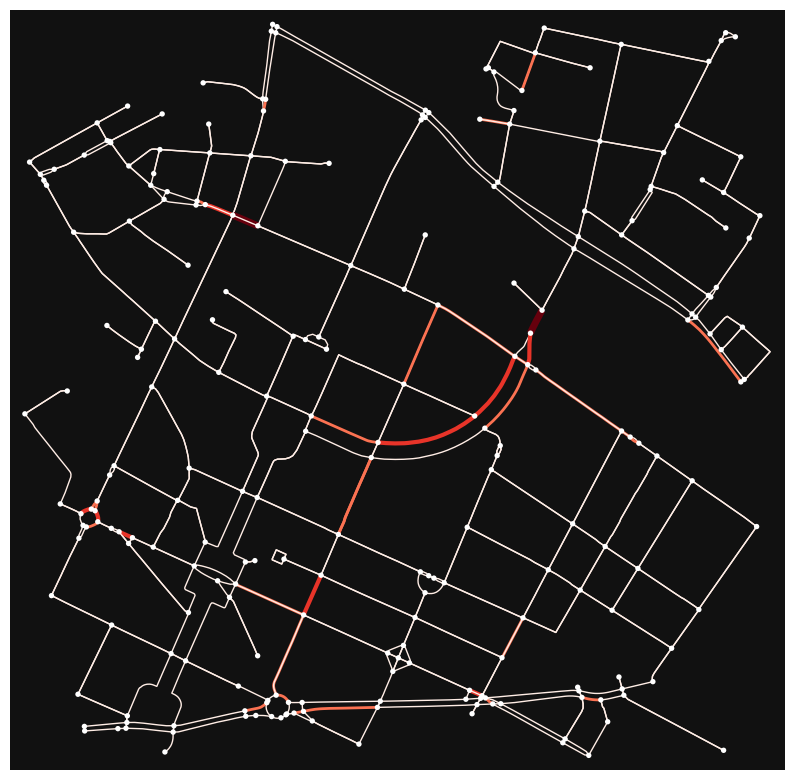

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [6]:
# Run the traffic simulation
# 100 cars that will move for 10 time steps
simulation = TrafficSimulation(G, num_cars=100, num_steps=10)
cars = simulation.simulate_traffic()

#Visualize
visualizer = NetworkVisualizer(G)
visualizer.plot_network_with_traffic(cars)

# **Task 2.D - Improved Simulation**

In [7]:
#Traffic Simulation

class Car:
    """
    Represents a single car on the road network.
    A car is a simple object that has a location and knows where it wants to go.
    """

    def __init__(self, start, destination):
        """
        Create a car with a starting location and destination.

        Args:
            start: Starting intersection (node), where the car begins
            destination: Destination intersection (node), where the car wants to go

        The car doesn't have a route yet.
        """
        self.current_location = start
        self.destination = destination
        # This will store the path (list of streets/nodes) the car needs to follow
        self.path = []

        # IMPROVEMENT
        # Track position along the current edge (0.0 = at start node, 1.0 = at end node)
        # This allows cars to move along roads instead of teleporting
        self.position_on_edge = 0.0
        # The next node the car is traveling towards (None if not on an edge)
        self.next_node = None
        # Current speed of the car (affected by congestion)
        self.current_speed = 1.0

class TrafficSimulation:
    """
    Manages traffic simulation on a road network.
    This is the main class that controls the entire simulation. It creates cars, moves them every time step,
    and checks for traffic jams
    """

    def __init__(self, G, num_cars=100, num_steps=None, max_steps=1000):
        """
        Initialize the simulation.

        Args:
            G: The road network graph (the map of streets)
            num_cars: How many cars to simulate (default is set to 100)
            num_steps: How many simulation steps to run. If None, runs until all cars
                       reach their destination (or max_steps is reached)
            max_steps: Safety limit to prevent infinite loops (default 1000)

        A 'step' is one time unit. Each step, all cars move forward based on
        their speed (which depends on traffic density).
        """
        self.G = G
        self.num_cars = num_cars
        self.num_steps = num_steps
        self.max_steps = max_steps  # Safety limit to prevent infinite simulation
        self.cars = []  # Will be filled with Car objects

        # IMPROVEMENT
        # Greenshields model parameters for density-dependent speed
        # These values are based on typical traffic engineering standards

        # Base capacity per lane (cars per km) - used to calculate jam density
        # Typical values: 150-250 vehicles/km/lane for highways
        self.base_jam_density = 200 # Cars per km at maximum jam

        # Minimum speed multiplier (even in heavy traffic, cars don't fully stop)
        self.min_speed_factor = 0.1

        # Road type capacity multipliers (different roads handle different traffic)
        # Primary roads (4 lane) can handle more traffic than residential streets
        self.road_capacity = {'motorway': 2.0, 'trunk': 1.8, 'primary': 1.5, 'secondary': 1.2, 'tertiary': 1.0, 'residential': 0.6, 'default': 1.0}

    # IMPROVEMENT
    def _get_edge_capacity(self, u, v):
        """
        Get the capacity (jam density) for a specific edge based on road type.

        Different road types can handle different amounts of traffic:
        - Highways/motorways: Can handle many cars (high capacity)
        - Residential streets: Can only handle few cars (low capacity)

        Args:
            u: Start node of the edge
            v: End node of the edge

        Returns:
            float: The jam density (max cars) for this edge
        """
        # Get edge data (there might be multiple edges between nodes, take first)
        edge_data = self.G.get_edge_data(u, v)
        if edge_data is None:
            return self.base_jam_density

        # Get the first edge if there are multiple
        if isinstance(edge_data, dict) and 0 in edge_data:
            edge_data = edge_data[0]

        # Get road type (highway tag in OSM data)
        highway_type = edge_data.get('highway', 'default')
        if isinstance(highway_type, list):
            highway_type = highway_type[0]

        # Get the capacity multiplier for this road type
        capacity_mult = self.road_capacity.get(highway_type, self.road_capacity['default'])

        # Get edge length in km (length is in meters)
        length_km = edge_data.get('length', 100) / 1000

        # Capacity = base_jam_density * road_multiplier * length
        # (Longer roads can hold more cars)
        return self.base_jam_density * capacity_mult * max(length_km, 0.05)

    # IMPROVEMENT
    def _count_cars_on_edge(self, u, v):
        """
        Count how many cars are currently on a specific edge.

        Args:
            u: Start node of the edge
            v: End node of the edge

        Returns:
            int: Number of cars on this edge
        """
        count = 0
        for car in self.cars:
            if car.current_location == u and car.next_node == v:
                count += 1
        return count

    # IMPROVEMENT
    def _calculate_speed(self, u, v):
        """
        Calculate the speed on an edge using the Greenshields model.
        It gives us a speed-density relationship:
        v = v_free * (1 - density / jam_density)
        v = actual speed (what cars can travel at)
        v_free = free-flow speed (speed limit, when road is empty)
        density = current number of cars on the road
        jam_density = maximum cars the road can hold (gridlock)

        Empty roads = cars drive at speed limit
        Busy roads = cars slow down
        Very congested roads = cars nearly stop

        Args:
            u: Start node of the edge
            v: End node of the edge

        Returns:
            float: Speed multiplier (1.0 = free flow, 0.1 = very congested)
        """
        # Current density: how many cars are on this edge?
        current_cars = self._count_cars_on_edge(u, v)

        # Jam density: how many cars can this edge hold before gridlock?
        jam_density = self._get_edge_capacity(u, v)

        # Greenshields formula: v = v_free * (1 - density/jam_density)
        # We calculate the ratio: current_density / jam_density
        density_ratio = current_cars / jam_density if jam_density > 0 else 0

        # Speed_factor = 1 - density_ratio
        speed_factor = max(self.min_speed_factor, 1.0 - density_ratio)

        return speed_factor

    def move_cars(self):
        """
        Move all cars one step forward.
        """
        for car in self.cars:
            # Does this car know where to go?
            if not car.path and car.next_node is None:
                # Find the shortest path from current location to destination
                # We use 'travel_time' as the weight (cause it prefers faster routes)
                try:
                    full_path = nx.shortest_path(self.G, car.current_location, car.destination, weight="travel_time")
                    # Remove the starting node (where the car already is) from the path
                    car.path = full_path[1:]
                except nx.NetworkXNoPath:
                    # No route exists to this destination (can happen in real maps)
                    # Just mark the car as already at destination so it stops trying
                    car.current_location = car.destination
                    continue

            # Has the car reached its destination?
            if car.current_location == car.destination:
                continue

            #IMPROVEMENT
            # If car is not currently on an edge, start on the next one
            if car.next_node is None and car.path:
                car.next_node = car.path.pop(0)
                car.position_on_edge = 0.0

            # If car has somewhere to go
            if car.next_node is not None:
                # Calculate speed based on traffic density
                speed = self._calculate_speed(car.current_location, car.next_node)
                car.current_speed = speed

                # Move the car along the edge
                # In one time step, car moves by 'speed' amount (1.0 = full edge)
                # We use 0.3 as base movement so it takes about 3 steps to cross empty road
                car.position_on_edge += speed * 0.3

                # Has the car reached the end of this edge?
                if car.position_on_edge >= 1.0:
                    # Move to the next node
                    car.current_location = car.next_node
                    car.next_node = None
                    car.position_on_edge = 0.0

    def simulate_traffic(self):
        """
        Run the traffic simulation.

        1. Create random cars with random starts and destinations
        2. For each time step, move all cars and print progress
        3. Stop when all cars reach destination (or max_steps/num_steps is reached)
        4. Return the list of all cars after simulation finishes
        """
        # Get all intersections (nodes) in the map
        nodes = list(self.G.nodes())

        # Create random cars - each starts and ends at a random intersection
        self.cars = [Car(random.choice(nodes), random.choice(nodes)) for _ in range(self.num_cars)]

        # Determine how many steps to run
        # If num_steps is None, run until all cars arrive (up to max_steps)
        steps_limit = self.num_steps if self.num_steps is not None else self.max_steps

        # Run the simulation
        step = 0
        while step < steps_limit:
            # Move all cars one step
            self.move_cars()
            step += 1

            # Print progress (how many cars reached their destination)
            cars_at_dest = sum(1 for c in self.cars if c.current_location == c.destination)

            # IMPROVEMENT
            # Also show average speed to see congestion effects
            moving_cars = [c for c in self.cars if c.current_location != c.destination]
            avg_speed = sum(c.current_speed for c in moving_cars) / len(moving_cars) if moving_cars else 1.0
            print(f"Step {step}: Cars at destination: {cars_at_dest}/{self.num_cars}, Avg speed: {avg_speed:.2f}")

            # Stop early if all cars have reached their destination
            if cars_at_dest == self.num_cars:
                print(f"\n✓ All cars reached their destination in {step} steps!")
                break

        # Warn if we hit the step limit without all cars arriving
        if step >= steps_limit and cars_at_dest < self.num_cars:
            print(f"\n⚠ Reached step limit ({steps_limit}). {self.num_cars - cars_at_dest} cars still traveling.")

        return self.cars


class NetworkVisualizer:
    """
    Visualizes the road network with traffic.
    """

    def __init__(self, G):
        """
        Initialize with a road network.
        """
        self.G = G

    def edge_car_counts(self, cars):
        """
        Count the number of cars on each edge (street).
        An edge connects two intersections. We count how many cars are currently trying to drive on each edge.

        Returns a dictionary: {(from_node, to_node): number_of_cars, ...}
        """
        counts = {}
        for car in cars:
            #IMPROVEMENT
            # Check if car is currently on an edge (has a next_node)
            if car.next_node is not None:
                edge_key = (car.current_location, car.next_node)
                counts[edge_key] = counts.get(edge_key, 0) + 1
            # Also count cars that are about to enter an edge (for visualization)
            elif car.path:
                next_node = car.path[0]
                edge_key = (car.current_location, next_node)
                counts[edge_key] = counts.get(edge_key, 0) + 1
        return counts

    def plot_network_with_traffic(self, cars):
        """
        Plot the network showing traffic congestion.

        This creates a visual map:
          Light red = no cars or few cars on this street
          Dark red = many cars (traffic jam!)
          Thick lines = more cars
          Thin lines = fewer cars
        """
        edge_colors = []
        edge_widths = []

        # Get how many cars are on each street
        counts = self.edge_car_counts(cars)
        # Find the maximum number of cars on any single street (for color scaling)
        max_count = max(counts.values()) if counts.values() else 1

        # For each street in the map, decide its color and thickness
        for u, v, k in self.G.edges(keys=True):
            # How many cars are on this street? (default: 0 if none)
            count = counts.get((u, v), 0)

            # Decide the color
            if count == 0:
                # No cars, very light red
                edge_colors.append(plt.cm.Reds(0.05))
            else:
                # Some cars, darker red depending on how many
                # Formula: darker red = more traffic
                intensity = min(1.0, 0.3 + (count / max_count) * 0.7)
                edge_colors.append(plt.cm.Reds(intensity))

            # Line thickness (thicker = more cars)
            edge_widths.append(1 + count)

        # Draw the map
        fig, ax = ox.plot_graph(self.G, figsize=(10, 10), edge_color=edge_colors, edge_linewidth=edge_widths)
        return fig, ax

Step 1: Cars at destination: 1/100, Avg speed: 0.92
Step 2: Cars at destination: 1/100, Avg speed: 0.91
Step 3: Cars at destination: 1/100, Avg speed: 0.91
Step 4: Cars at destination: 1/100, Avg speed: 0.92
Step 5: Cars at destination: 1/100, Avg speed: 0.91
Step 6: Cars at destination: 1/100, Avg speed: 0.89
Step 7: Cars at destination: 1/100, Avg speed: 0.89
Step 8: Cars at destination: 3/100, Avg speed: 0.89
Step 9: Cars at destination: 3/100, Avg speed: 0.90
Step 10: Cars at destination: 3/100, Avg speed: 0.90

⚠ Reached step limit (10). 97 cars still traveling.


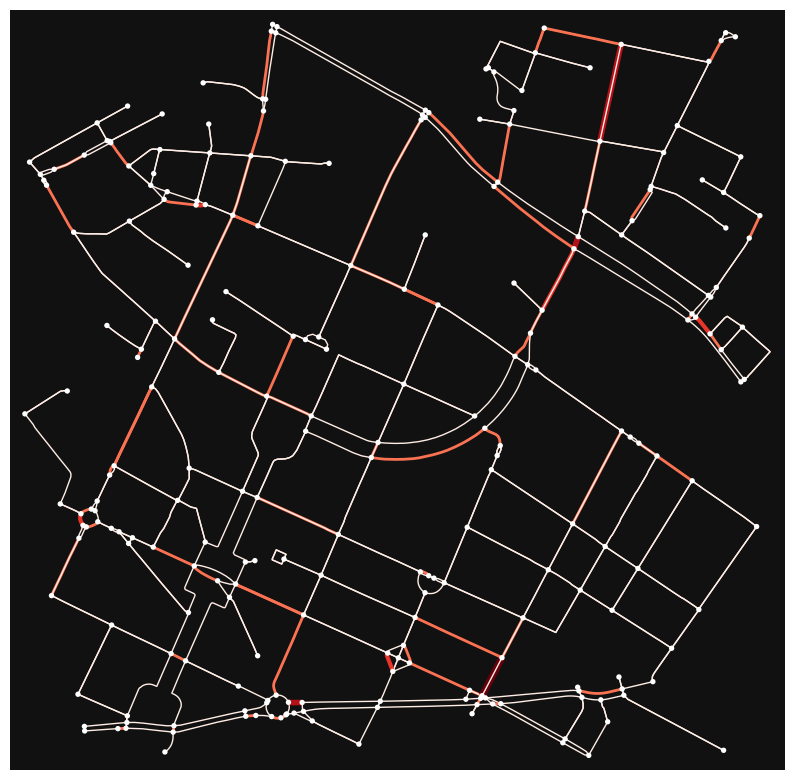

(<Figure size 1000x1000 with 1 Axes>, <Axes: >)

In [8]:
# Run the traffic simulation
# Simulation runs until all cars reach destination (or max 500 steps)
simulation = TrafficSimulation(G, num_cars=100, num_steps=10, max_steps=None)
cars = simulation.simulate_traffic()

#Visualize
visualizer = NetworkVisualizer(G)
visualizer.plot_network_with_traffic(cars)

# **Task 3 - Improved Visualization**

In [9]:
# IMPROVED VISUALIZATION
# The problem with the original visualization is that it only shows traffic at the FINAL time step.
# By then, most cars have arrived at their destinations, so roads appear empty
# We need to track congestion OVER TIME to see which roads are consistently busy.

class ImprovedTrafficSimulation(TrafficSimulation):
    """
    Extended TrafficSimulation that tracks congestion history for better visualization.
    """

    def __init__(self, G, num_cars=100, num_steps=None, max_steps=1000):
        """
        Initialize the simulation with congestion tracking.
        """
        super().__init__(G, num_cars, num_steps, max_steps)
        # Track total cars on each edge across ALL time steps
        # This helps identify roads that are consistently congested
        self.congestion_history = {}

    def _update_congestion_history(self):
        """
        Record current traffic on each edge to build congestion history.
        Called every time step to accumulate which roads are used most.
        Roads with high counts are consistently congested (bottlenecks).
        """
        for car in self.cars:
            if car.next_node is not None:
                edge_key = (car.current_location, car.next_node)
                self.congestion_history[edge_key] = self.congestion_history.get(edge_key, 0) + 1

    def simulate_traffic(self):
        """
        Run the traffic simulation with congestion history tracking.
        """
        nodes = list(self.G.nodes())
        self.cars = [Car(random.choice(nodes), random.choice(nodes)) for _ in range(self.num_cars)]

        # Reset congestion history for new simulation
        self.congestion_history = {}

        steps_limit = self.num_steps if self.num_steps is not None else self.max_steps

        step = 0
        while step < steps_limit:
            self.move_cars()
            step += 1

            # Record congestion at this time step
            self._update_congestion_history()

            cars_at_dest = sum(1 for c in self.cars if c.current_location == c.destination)
            moving_cars = [c for c in self.cars if c.current_location != c.destination]
            avg_speed = sum(c.current_speed for c in moving_cars) / len(moving_cars) if moving_cars else 1.0
            print(f"Step {step}: Cars at destination: {cars_at_dest}/{self.num_cars}, Avg speed: {avg_speed:.2f}")

            if cars_at_dest == self.num_cars:
                print(f"\n✓ All cars reached their destination in {step} steps!")
                break

        if step >= steps_limit and cars_at_dest < self.num_cars:
            print(f"\n⚠ Reached step limit ({steps_limit}). {self.num_cars - cars_at_dest} cars still traveling.")

        return self.cars


class ImprovedNetworkVisualizer(NetworkVisualizer):
    """
    Enhanced visualization that shows cumulative congestion patterns.
    Uses a green-yellow-red color scheme (like traffic lights) instead of just red shades.
    Highlights the most congested road in cyan.
    """

    def plot_cumulative_congestion(self, simulation, top_n=10):
        """
        Plot the network showing CUMULATIVE congestion over the entire simulation.

        This is much better than showing just the final snapshot because:
        Shows which roads were busy throughout the simulation
        Identifies bottlenecks and congestion hotspots
        Doesn't miss congestion that occurred earlier

        Colors:
        Green = Roads with low/no traffic (clear roads)
        Yellow = Roads with moderate traffic
        Red = Roads with high traffic (congested)
        Cyan = The #1 most congested road (special highlight)

        Args:
            simulation: The ImprovedTrafficSimulation object (after running simulate_traffic())
            top_n: Number of most congested roads to show in the report
        """
        edge_colors = []
        edge_widths = []

        # Get cumulative congestion data from simulation
        counts = simulation.congestion_history
        max_count = max(counts.values()) if counts.values() else 1

        # Find the most congested edge to highlight it with special color
        max_count = max(counts.values()) if counts.values() else 1
        top_edges = {edge for edge, c in counts.items() if c == max_count}

        # Create the colormap: Green (clear) -> Yellow (moderate) -> Red (congested)
        from matplotlib.colors import LinearSegmentedColormap, to_rgba
        colors_list = ['#2ecc71', '#f1c40f', '#e74c3c'] #Green, Yellow, Red
        cmap = LinearSegmentedColormap.from_list('traffic', colors_list)
        cyan_rgba = to_rgba('#00FFFF')

        # For each street in the map, decide its color and thickness
        for u, v, k in self.G.edges(keys=True):
            count = counts.get((u, v), 0)

            # Calculate congestion ratio (0 = empty, 1 = max congestion)
            congestion_ratio = count / max_count if max_count > 0 else 0

            if (u, v) in top_edges:
                edge_colors.append(cyan_rgba)
                edge_widths.append(5)
            else:
                edge_colors.append(cmap(congestion_ratio))
                edge_widths.append(1 + congestion_ratio * 3)

        # Plot
        fig, ax = ox.plot_graph(self.G, figsize=(12, 12), edge_color=edge_colors, edge_linewidth=edge_widths, node_size=15, node_color='white', show=False, close=False)

        # Add title
        ax.set_title("Cumulative Traffic Congestion\n(Green = Clear, Red = Congested, Cyan = #1 Hotspot)", fontsize=14)

        # Add colorbar legend with custom colormap
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_count))
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.7, label='Total Cars Over Time')
        cbar.ax.yaxis.label.set_color('black')
        cbar.ax.tick_params(colors='black')

        plt.show()

        # Print report of most congested roads
        print("\n" + "*"*60)
        print(f"Top {top_n} most congested roads")
        print("*"*60)

        # Sort edges by congestion
        sorted_edges = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

        for i, ((u, v), count) in enumerate(sorted_edges, 1):
            # Try to get street name
            edge_data = self.G.get_edge_data(u, v)
            if edge_data and 0 in edge_data:
                edge_data = edge_data[0]
            street_name = edge_data.get('name', 'Unnamed road') if edge_data else 'Unknown'
            if isinstance(street_name, list):
                street_name = street_name[0]

            congestion_pct = (count / max_count) * 100
            # Add special marker for #1
            print(f"{i} {street_name}: {count} car-steps ({congestion_pct:.1f}% of max)")

        return fig, ax

Step 1: Cars at destination: 1/100, Avg speed: 0.91
Step 2: Cars at destination: 1/100, Avg speed: 0.90
Step 3: Cars at destination: 1/100, Avg speed: 0.90
Step 4: Cars at destination: 2/100, Avg speed: 0.91
Step 5: Cars at destination: 2/100, Avg speed: 0.91
Step 6: Cars at destination: 2/100, Avg speed: 0.89
Step 7: Cars at destination: 2/100, Avg speed: 0.89
Step 8: Cars at destination: 4/100, Avg speed: 0.89
Step 9: Cars at destination: 4/100, Avg speed: 0.90
Step 10: Cars at destination: 4/100, Avg speed: 0.91
Step 11: Cars at destination: 4/100, Avg speed: 0.90
Step 12: Cars at destination: 5/100, Avg speed: 0.89
Step 13: Cars at destination: 5/100, Avg speed: 0.88
Step 14: Cars at destination: 5/100, Avg speed: 0.89
Step 15: Cars at destination: 5/100, Avg speed: 0.90
Step 16: Cars at destination: 8/100, Avg speed: 0.90
Step 17: Cars at destination: 8/100, Avg speed: 0.89
Step 18: Cars at destination: 8/100, Avg speed: 0.89
Step 19: Cars at destination: 8/100, Avg speed: 0.89
St

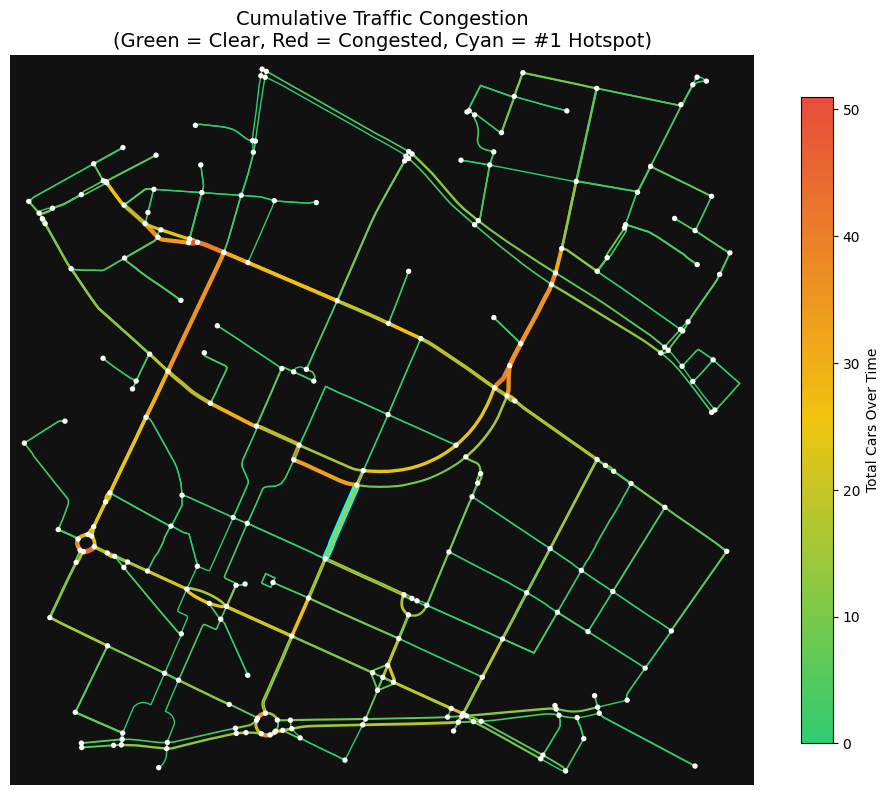


************************************************************
Top 10 most congested roads
************************************************************
1 Adalbertstraße: 51 car-steps (100.0% of max)
2 Köpenicker Straße: 50 car-steps (98.0% of max)
3 Unnamed road: 45 car-steps (88.2% of max)
4 Bethaniendamm: 41 car-steps (80.4% of max)
5 Engeldamm: 40 car-steps (78.4% of max)
6 Köpenicker Straße: 40 car-steps (78.4% of max)
7 An der Schillingbrücke: 38 car-steps (74.5% of max)
8 Leuschnerdamm: 37 car-steps (72.5% of max)
9 Inselstraße: 37 car-steps (72.5% of max)
10 Kottbusser Tor: 36 car-steps (70.6% of max)


(<Figure size 1200x1200 with 2 Axes>,
 <Axes: title={'center': 'Cumulative Traffic Congestion\n(Green = Clear, Red = Congested, Cyan = #1 Hotspot)'}>)

In [10]:
# Run the improved simulation with congestion tracking
simulation = ImprovedTrafficSimulation(G, num_cars=100, num_steps=None, max_steps=500)
cars = simulation.simulate_traffic()

# Use the improved visualization to identify congested roads
visualizer = ImprovedNetworkVisualizer(G)
visualizer.plot_cumulative_congestion(simulation, top_n=10)

# **Task 4.A**

************************************************************
Top 10 most congested roads (summed over 100 simulations)
************************************************************
1. An der Schillingbrücke: 4898 car-steps
2. Bethaniendamm: 4649 car-steps
3. Engeldamm: 4612 car-steps
4. Bethaniendamm: 4214 car-steps
5. Bethaniendamm: 4185 car-steps
6. Schillingbrücke: 4074 car-steps
7. Köpenicker Straße: 4069 car-steps
8. Schillingbrücke: 3948 car-steps
9. Unnamed road: 3175 car-steps
10. Adalbertstraße: 2985 car-steps


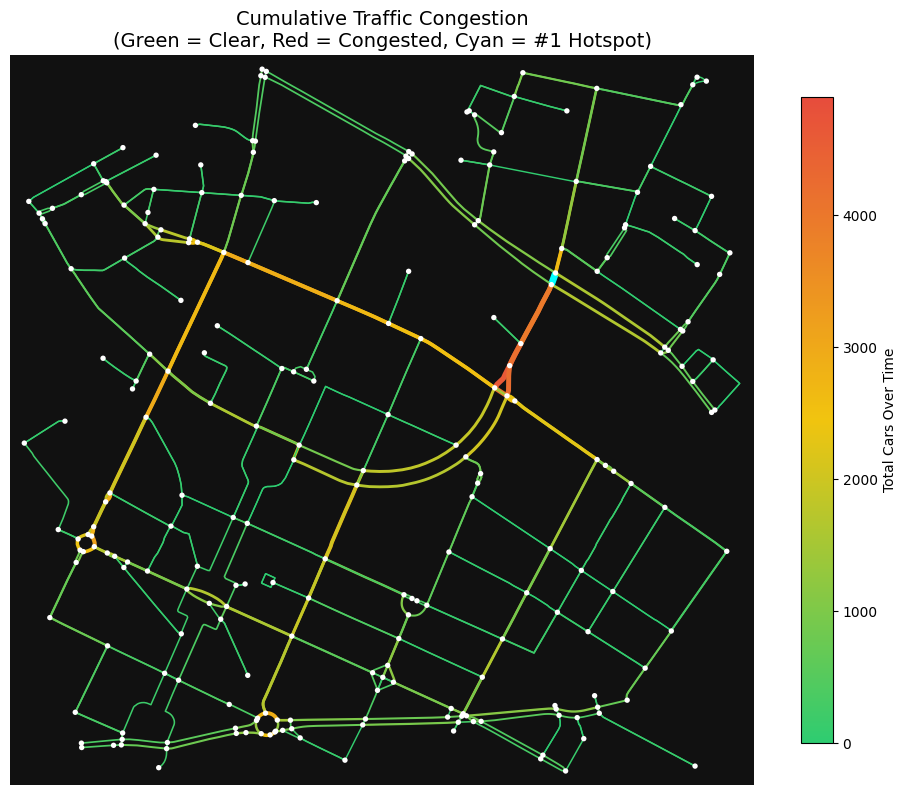


************************************************************
Top 10 most congested roads
************************************************************
1 An der Schillingbrücke: 4898 car-steps (100.0% of max)
2 Bethaniendamm: 4649 car-steps (94.9% of max)
3 Engeldamm: 4612 car-steps (94.2% of max)
4 Bethaniendamm: 4214 car-steps (86.0% of max)
5 Bethaniendamm: 4185 car-steps (85.4% of max)
6 Schillingbrücke: 4074 car-steps (83.2% of max)
7 Köpenicker Straße: 4069 car-steps (83.1% of max)
8 Schillingbrücke: 3948 car-steps (80.6% of max)
9 Unnamed road: 3175 car-steps (64.8% of max)
10 Adalbertstraße: 2985 car-steps (60.9% of max)


(<Figure size 1200x1200 with 2 Axes>,
 <Axes: title={'center': 'Cumulative Traffic Congestion\n(Green = Clear, Red = Congested, Cyan = #1 Hotspot)'}>)

In [11]:
# Task 4.a: Run Multiple Simulations and Analyze Congestion Patterns
# Same class as before, but doesn't print every step
class NewSimulation(ImprovedTrafficSimulation):
    def simulate_traffic(self):
        # Pick random start/end points for all cars
        nodes = list(self.G.nodes())
        self.cars = [Car(random.choice(nodes), random.choice(nodes)) for _ in range(self.num_cars)]
        self.congestion_history = {}
        steps_limit = self.num_steps if self.num_steps is not None else self.max_steps

        # Run the simulation without printing
        step = 0
        while step < steps_limit:
            self.move_cars()
            step += 1
            self._update_congestion_history()
            # Stop early if everyone arrived
            if sum(1 for c in self.cars if c.current_location == c.destination) == self.num_cars:
                break
        return self.cars

# Run 100 simulations and ADD UP all the congestion data
# This is like taking 100 "samples" to find the real congestion hotspots
aggregated_congestion = {}
for i in range(100):
    sim = NewSimulation(G, num_cars=100, max_steps=200) #I increased the number of cars to make it a bit more realistic
    sim.simulate_traffic()

    # Add this simulation's congestion to our total
    for edge, count in sim.congestion_history.items():
        aggregated_congestion[edge] = aggregated_congestion.get(edge, 0) + count

# Find the top 10 most congested roads (sorted by total car-steps)
top_congested = sorted(aggregated_congestion.items(), key=lambda x: x[1], reverse=True)[:10]

# Print the ranking
print("*"*60)
print("Top 10 most congested roads (summed over 100 simulations)")
print("*"*60)

for rank, (edge, total) in enumerate(top_congested, 1):
    # Get the street name from the graph data
    edge_data = G.get_edge_data(edge[0], edge[1])
    if edge_data and 0 in edge_data:
        edge_data = edge_data[0]
    street_name = edge_data.get('name', 'Unnamed road') if edge_data else 'Unknown'
    if isinstance(street_name, list):
        street_name = street_name[0]
    print(f"{rank}. {street_name}: {total} car-steps")

# Visualize the results using our green-yellow-red colormap from Task 3
# We wrap our data in a simple class so it works with the visualizer
class AggregatedSimulation:
    def __init__(self, congestion_history):
        self.congestion_history = congestion_history

agg_sim = AggregatedSimulation(aggregated_congestion)
visualizer = ImprovedNetworkVisualizer(G)
visualizer.plot_cumulative_congestion(agg_sim, top_n=10)

# **Task 4.B**

************************************************************
Which metric predicts congestion?
************************************************************

Edge Betweenness vs Congestion:
Pearson correlation (r): 0.6248
R² (variance explained): 0.3904 (39.0%)
p-value: 1.06e-59 (significant!)

Degree Centrality vs Congestion:
Pearson correlation (r): 0.0446
R² (variance explained): 0.0020 (0.2%)
p-value: 3.01e-01 

Top-10 overlap analysis:
Betweenness top-10 matches 6/10 congested roads
Degree top-10 matches 0/10 congested roads


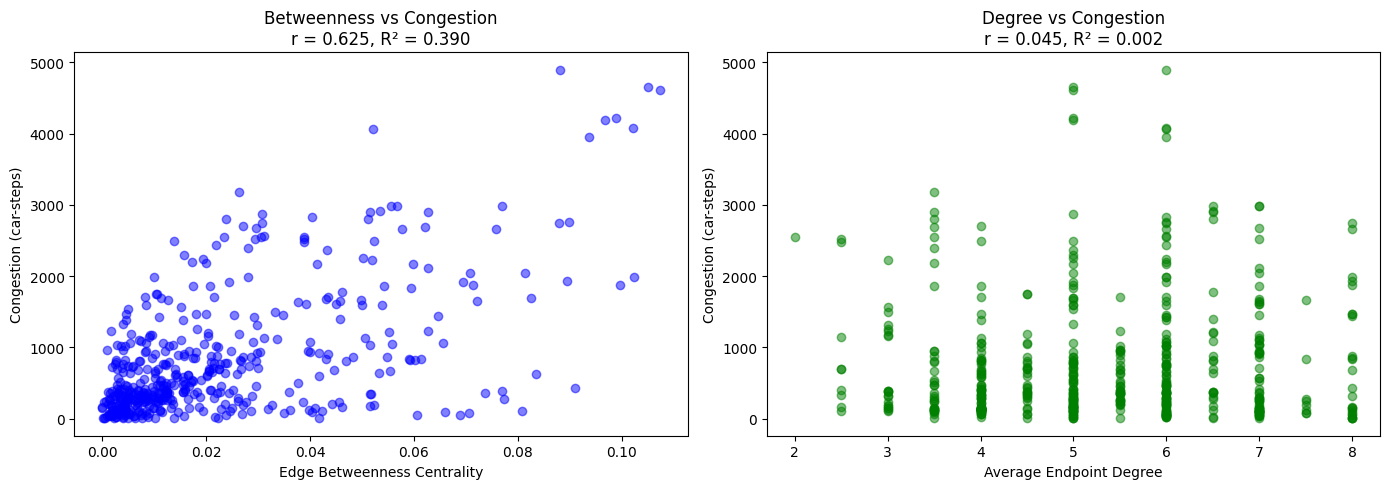


Best predictor: Edge Betweenness Centrality
- Correlation (r): 0.6248
- R² (variance explained): 0.3904 (39.0%)
- Top-10 overlap: 6/10 roads


In [12]:
# Task 4.b: Find Network Metrics that Predict Congestion
# We want to find which network metric best predicts where traffic congestion happen.
# Two good candidates from Chapter 17 of Sayama:
# Edge Betweenness Centrality: how many shortest paths go through this road?
# Degree Centrality: how many roads connect to each intersection?


# Edge Betweenness Centrality
# This measures how "important" each road is for connecting the network
# Roads with high betweenness are on many shortest paths = likely bottlenecks
edge_betweenness = nx.edge_betweenness_centrality(G)

# Degree-based metric for edges
# For each edge (u,v), we use the average degree of its endpoints
# Roads connecting high-degree intersections might be busier
node_degree = dict(G.degree())
edge_degree = {}
for u, v, k in G.edges(keys=True):
    edge_degree[(u, v)] = (node_degree[u] + node_degree[v]) / 2

# Match metrics with congestion from Task 4.a
# We compare: metric value vs. actual congestion (car-steps)
edges_with_data = []
for edge in aggregated_congestion.keys():
    congestion = aggregated_congestion[edge]

    # Get betweenness (handle both (u,v) and (u,v,k) keys)
    betweenness = edge_betweenness.get(edge, edge_betweenness.get((edge[0], edge[1], 0), 0))

    # Get degree
    degree = edge_degree.get(edge, 0)

    edges_with_data.append({'edge': edge, 'congestion': congestion, 'betweenness': betweenness, 'degree': degree})

# Extract lists for correlation
congestion_vals = [e['congestion'] for e in edges_with_data]
betweenness_vals = [e['betweenness'] for e in edges_with_data]
degree_vals = [e['degree'] for e in edges_with_data]

# Correlations and R² values
# R² tells us what percentage of congestion variation is explained by the metric
corr_betweenness, p_betweenness = stats.pearsonr(betweenness_vals, congestion_vals)
corr_degree, p_degree = stats.pearsonr(degree_vals, congestion_vals)
r2_betweenness = corr_betweenness ** 2
r2_degree = corr_degree ** 2

print("*"*60)
print("Which metric predicts congestion?")
print("*"*60)
print(f"\nEdge Betweenness vs Congestion:")
print(f"Pearson correlation (r): {corr_betweenness:.4f}")
print(f"R² (variance explained): {r2_betweenness:.4f} ({r2_betweenness*100:.1f}%)")
print(f"p-value: {p_betweenness:.2e} {'(significant!)' if p_betweenness < 0.05 else ''}")

print(f"\nDegree Centrality vs Congestion:")
print(f"Pearson correlation (r): {corr_degree:.4f}")
print(f"R² (variance explained): {r2_degree:.4f} ({r2_degree*100:.1f}%)")
print(f"p-value: {p_degree:.2e} {'(significant!)' if p_degree < 0.05 else ''}")

# Compare Top-K overlap
k = 10

# Top k by congestion (from Task 4.a)
top_congested_edges = [e['edge'] for e in sorted(edges_with_data, key=lambda x: x['congestion'], reverse=True)[:k]]

# Top k by betweenness
top_betweenness_edges = [e['edge'] for e in sorted(edges_with_data, key=lambda x: x['betweenness'], reverse=True)[:k]]

# Top k by degree
top_degree_edges = [e['edge'] for e in sorted(edges_with_data, key=lambda x: x['degree'], reverse=True)[:k]]

# Count overlaps
overlap_betweenness = len(set(top_congested_edges) & set(top_betweenness_edges))
overlap_degree = len(set(top_congested_edges) & set(top_degree_edges))

print(f"\nTop-{k} overlap analysis:")
print(f"Betweenness top-{k} matches {overlap_betweenness}/{k} congested roads")
print(f"Degree top-{k} matches {overlap_degree}/{k} congested roads")

#Scatter Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

#Betweenness vs Congestion
axes[0].scatter(betweenness_vals, congestion_vals, alpha=0.5, c='blue')
axes[0].set_xlabel('Edge Betweenness Centrality')
axes[0].set_ylabel('Congestion (car-steps)')
axes[0].set_title(f'Betweenness vs Congestion\nr = {corr_betweenness:.3f}, R² = {r2_betweenness:.3f}')

#Degree vs Congestion
axes[1].scatter(degree_vals, congestion_vals, alpha=0.5, c='green')
axes[1].set_xlabel('Average Endpoint Degree')
axes[1].set_ylabel('Congestion (car-steps)')
axes[1].set_title(f'Degree vs Congestion\nr = {corr_degree:.3f}, R² = {r2_degree:.3f}')

plt.tight_layout()
plt.show()

#Conclusion

# Pick the best metric
if abs(corr_betweenness) > abs(corr_degree):
    best_metric = "Edge Betweenness Centrality"
    best_corr = corr_betweenness
    best_r2 = r2_betweenness
    best_overlap = overlap_betweenness
else:
    best_metric = "Degree Centrality"
    best_corr = corr_degree
    best_r2 = r2_degree
    best_overlap = overlap_degree

print(f"\nBest predictor: {best_metric}")
print(f"- Correlation (r): {best_corr:.4f}")
print(f"- R² (variance explained): {best_r2:.4f} ({best_r2*100:.1f}%)")
print(f"- Top-{k} overlap: {best_overlap}/{k} roads")

# **Task 4.C**

************************************************************
Buenos Aires: Does Edge Betweenness predict congestion?
************************************************************
Pearson correlation (r): 0.3073
R² (variance explained): 0.0944 (9.4%)
p-value: 2.64e-14 (significant!)

Top-10 Comparison Table:
-------------------------------------------------------
Road Name                 Congestion Rank Betweenness Rank
-------------------------------------------------------
Avenida Rivadavia         1               117            
Bolívar                   2               260            
Avenida Rivadavia         3               286            
Avenida Rivadavia         4               200            
Avenida Rivadavia         5               209            
Avenida La Rábida         6               3              
Avenida Leandro N. Alem   7               205            
Avenida Hipólito Yrigoye  8               130            
Avenida Belgrano          9               108            

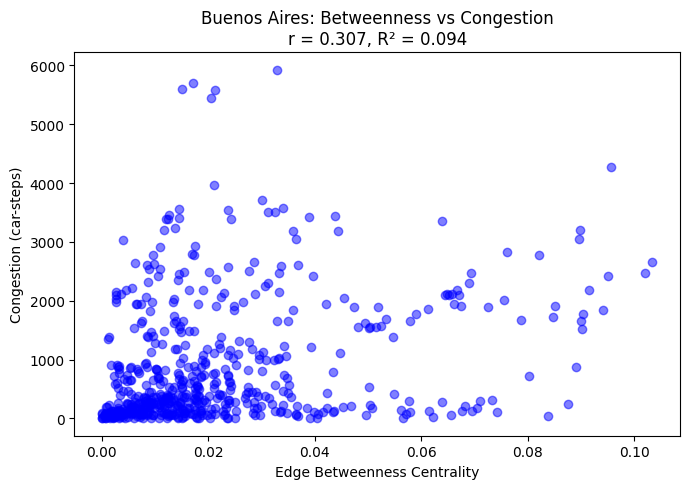

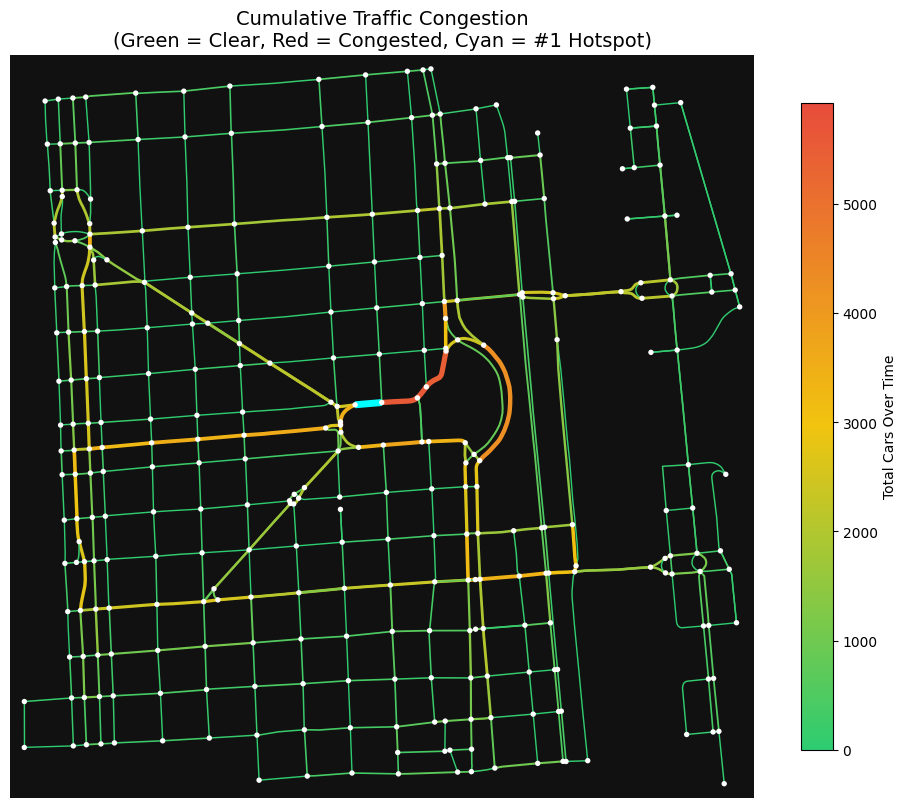


************************************************************
Top 10 most congested roads
************************************************************
1 Avenida Rivadavia: 5928 car-steps (100.0% of max)
2 Bolívar: 5693 car-steps (96.0% of max)
3 Avenida Rivadavia: 5599 car-steps (94.5% of max)
4 Avenida Rivadavia: 5580 car-steps (94.1% of max)
5 Avenida Rivadavia: 5442 car-steps (91.8% of max)
6 Avenida La Rábida: 4275 car-steps (72.1% of max)
7 Avenida Leandro N. Alem: 3960 car-steps (66.8% of max)
8 Avenida Hipólito Yrigoyen: 3717 car-steps (62.7% of max)
9 Avenida Belgrano: 3568 car-steps (60.2% of max)
10 Avenida de Mayo: 3558 car-steps (60.0% of max)


(<Figure size 1200x1200 with 2 Axes>,
 <Axes: title={'center': 'Cumulative Traffic Congestion\n(Green = Clear, Red = Congested, Cyan = #1 Hotspot)'}>)

In [13]:
# Task 4.c: Test the Predictor on Buenos Aires

# Load the Buenos Aires road network (same 1km radius as Berlin)
ba_network = NetworkLoader('Plaza de Mayo, Buenos Aires, Argentina', dist=1000)
G_ba = ba_network.G

# Run 100 simulations and add up all congestion (same as Task 4.a)
aggregated_congestion_ba = {}
for i in range(100):
    sim_ba = NewSimulation(G_ba, num_cars=100, max_steps=200)
    sim_ba.simulate_traffic()
    for edge, count in sim_ba.congestion_history.items():
        aggregated_congestion_ba[edge] = aggregated_congestion_ba.get(edge, 0) + count

# Compute edge betweenness centrality for Buenos Aires
edge_betweenness_ba = nx.edge_betweenness_centrality(G_ba)

# Match each edge's congestion with its betweenness value
edges_with_data_ba = []
for edge, congestion in aggregated_congestion_ba.items():
    bet = edge_betweenness_ba.get(edge, edge_betweenness_ba.get((edge[0], edge[1], 0), 0))
    edges_with_data_ba.append({'edge': edge, 'congestion': congestion, 'betweenness': bet})

# Extract lists for correlation
congestion_vals_ba = [e['congestion'] for e in edges_with_data_ba]
betweenness_vals_ba = [e['betweenness'] for e in edges_with_data_ba]

# Calculate correlation and R²
corr_ba, p_ba = stats.pearsonr(betweenness_vals_ba, congestion_vals_ba)
r2_ba = corr_ba ** 2

print("*" * 60)
print("Buenos Aires: Does Edge Betweenness predict congestion?")
print("*" * 60)
print(f"Pearson correlation (r): {corr_ba:.4f}")
print(f"R² (variance explained): {r2_ba:.4f} ({r2_ba*100:.1f}%)")
print(f"p-value: {p_ba:.2e} {'(significant!)' if p_ba < 0.05 else ''}")

# Assign ranks to each edge by congestion and by betweenness
sorted_by_congestion_ba = sorted(edges_with_data_ba, key=lambda x: x['congestion'], reverse=True)
sorted_by_betweenness_ba = sorted(edges_with_data_ba, key=lambda x: x['betweenness'], reverse=True)

for rank, e in enumerate(sorted_by_congestion_ba, 1):
    e['congestion_rank'] = rank
for rank, e in enumerate(sorted_by_betweenness_ba, 1):
    e['betweenness_rank'] = rank

# Top-10 overlap
k = 10
top_congested_ba = sorted_by_congestion_ba[:k]
top_betweenness_set = set(e['edge'] for e in sorted_by_betweenness_ba[:k])
top_congested_set = set(e['edge'] for e in top_congested_ba)
overlap_ba = len(top_congested_set & top_betweenness_set)

# Comparison table: metric rank vs congestion rank
print(f"\nTop-{k} Comparison Table:")
print("-" * 55)
print(f"{'Road Name':<25} {'Congestion Rank':<15} {'Betweenness Rank':<15}")
print("-" * 55)

for e in top_congested_ba:
    edge = e['edge']
    edge_data = G_ba.get_edge_data(edge[0], edge[1])
    if edge_data and 0 in edge_data:
        edge_data = edge_data[0]
    name = edge_data.get('name', 'Unnamed') if edge_data else 'Unknown'
    if isinstance(name, list):
        name = name[0]
    name = name[:24] if len(name) > 24 else name
    print(f"{name:<25} {e['congestion_rank']:<15} {e['betweenness_rank']:<15}")

print("-" * 55)
print(f"Top-{k} overlap: {overlap_ba}/{k} roads match")

# Scatter plot (same as Task 4.b)
plt.figure(figsize=(7, 5))
plt.scatter(betweenness_vals_ba, congestion_vals_ba, alpha=0.5, c='blue')
plt.xlabel('Edge Betweenness Centrality')
plt.ylabel('Congestion (car-steps)')
plt.title(f'Buenos Aires: Betweenness vs Congestion\nr = {corr_ba:.3f}, R² = {r2_ba:.3f}')
plt.tight_layout()
plt.show()

# Visualize the congestion map (same green-yellow-red colormap as Task 3)
agg_sim_ba = AggregatedSimulation(aggregated_congestion_ba)
visualizer_ba = ImprovedNetworkVisualizer(G_ba)
visualizer_ba.plot_cumulative_congestion(agg_sim_ba, top_n=10)